<hr style="border:30px solid Firebrick "> </hr>
<hr style="border:2px solid Firebrick "> </hr>

# Agentic Workflow Automation for AllState Auto Insurance
**Author:** Atef Bader, PhD

**Last Edit:** 2/8/2026



## Goals

- Automate Claim processing using Langgraph/Langchain with OpenAI
- Use OpenAI Multimodal reasoning to review, analyze, and process the Insurance Claims, Policyholder Insurance Declarations, and Vechile Damages

<hr style="border:2px solid Firebrick "> </hr>


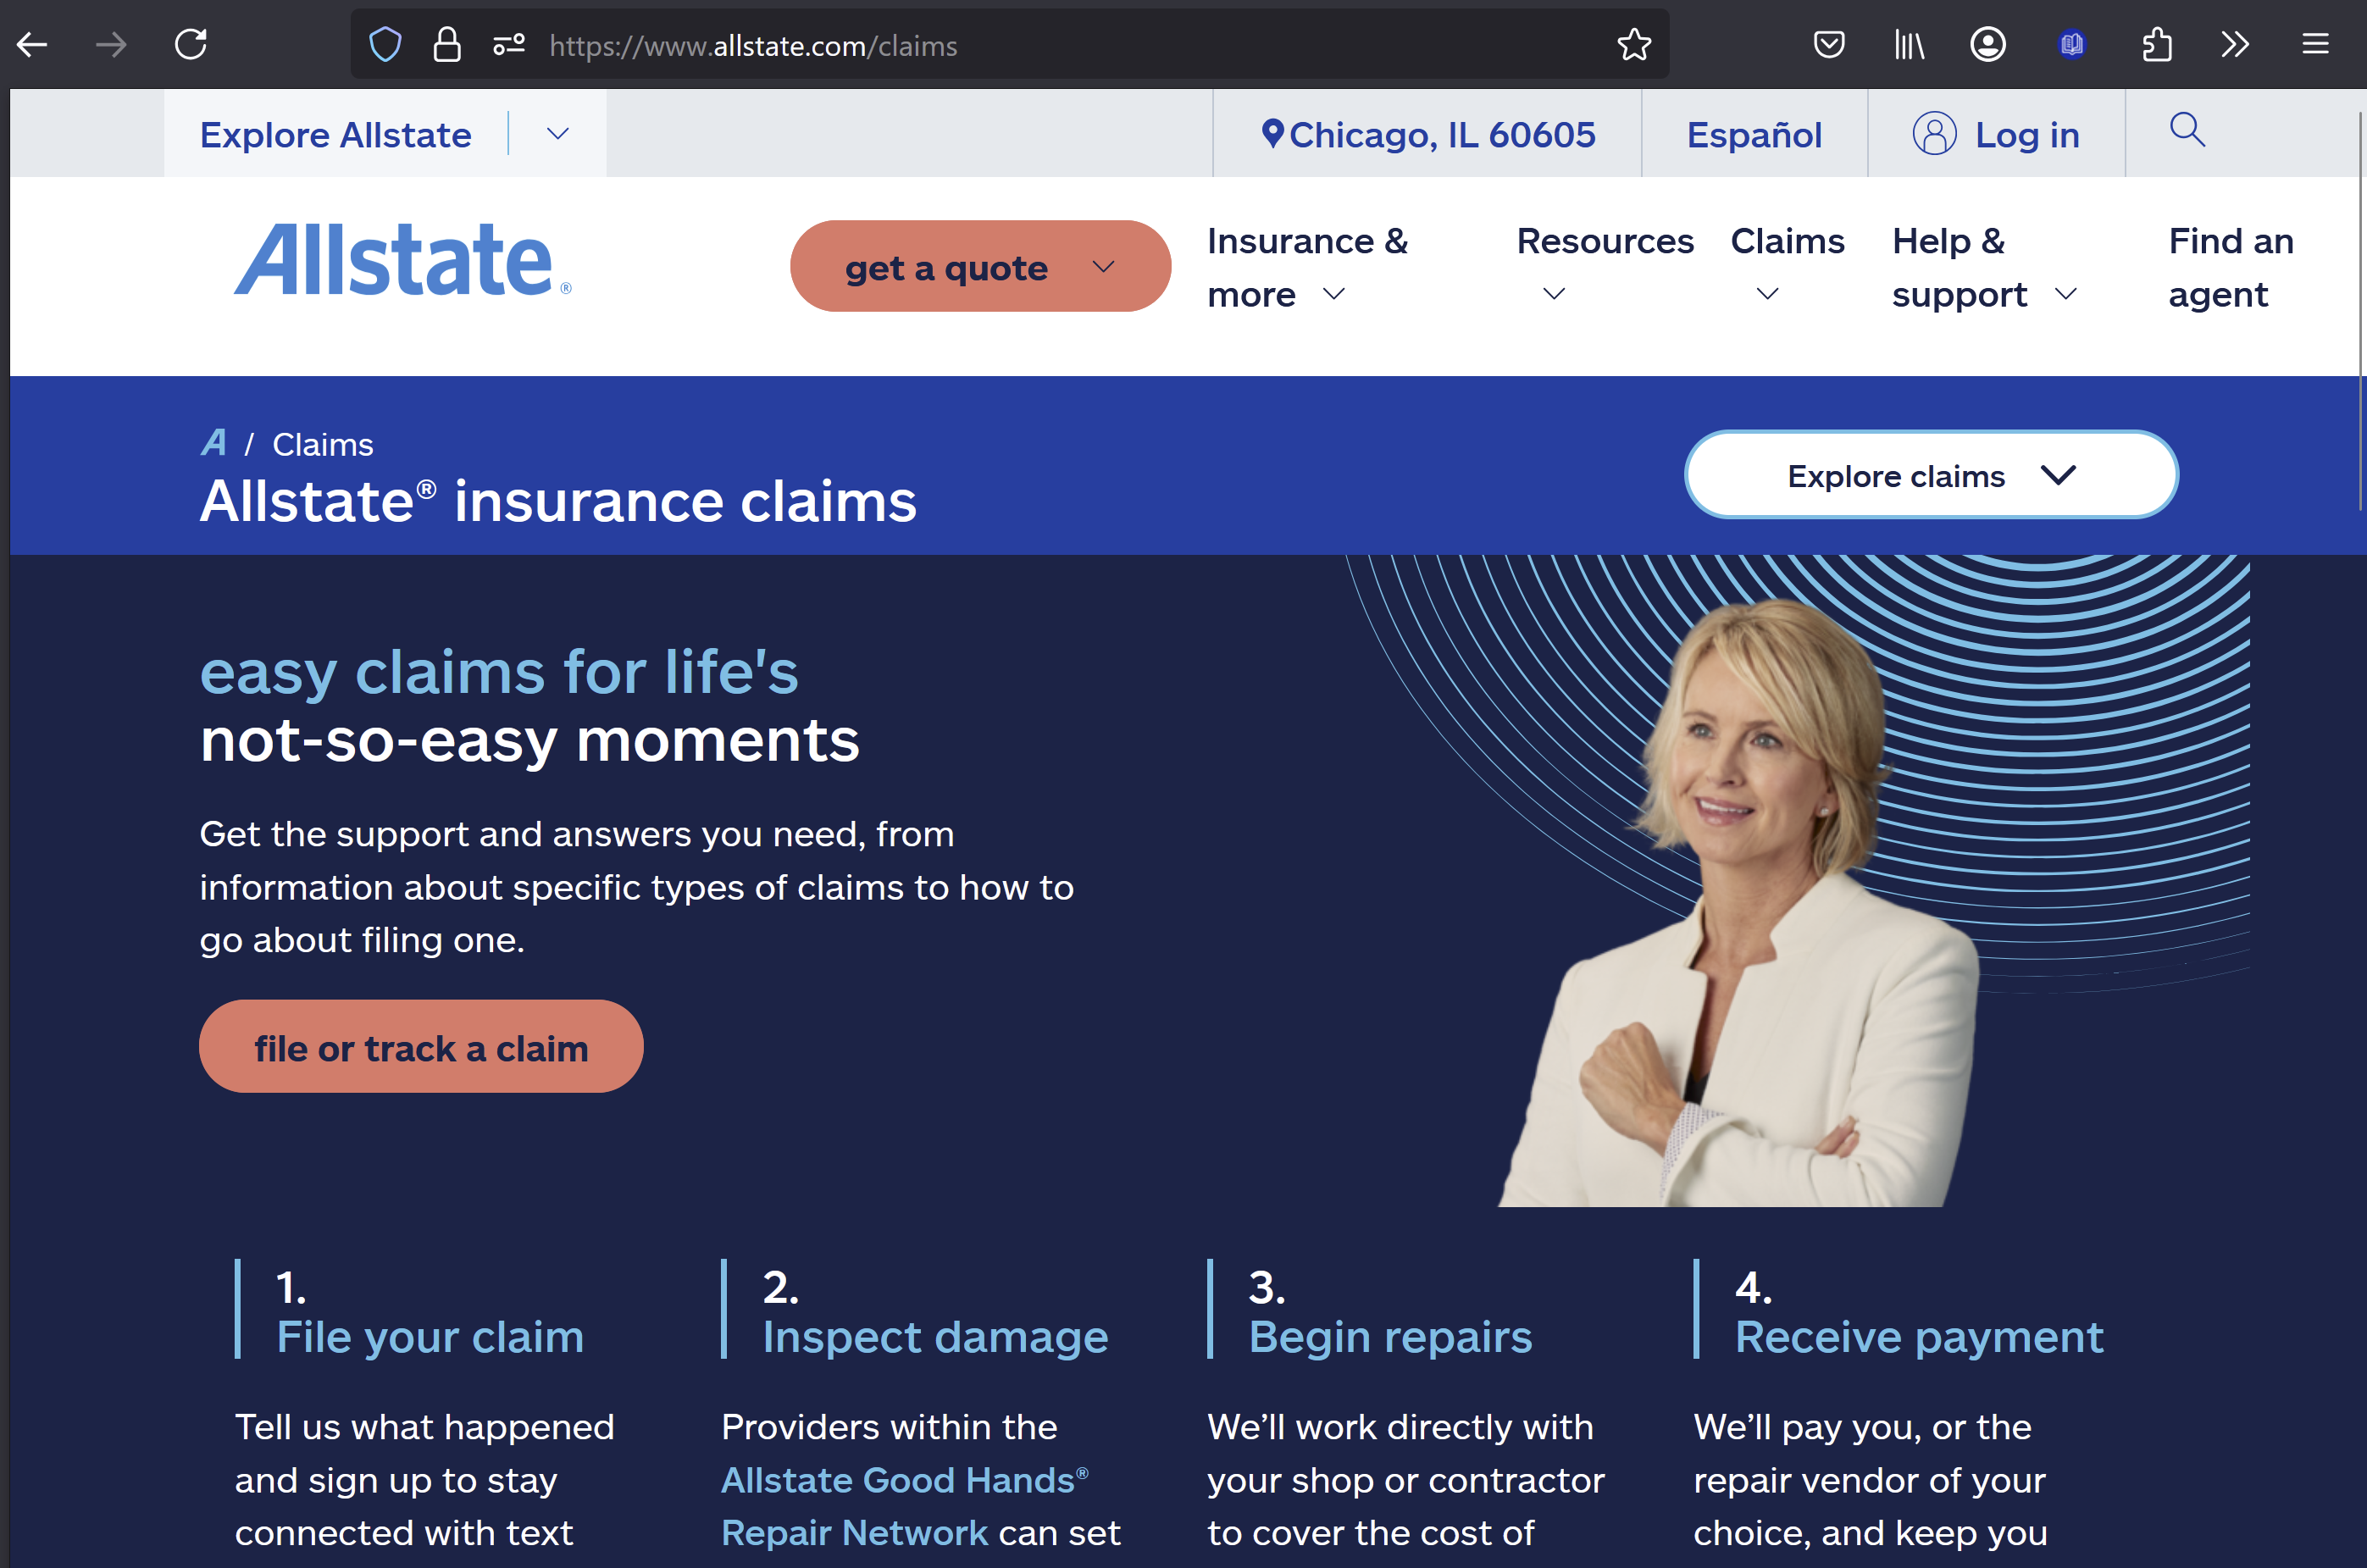


<hr style="border:5px solid orange "> </hr>



In [ ]:
%%capture --no-stderr
%pip install uv
%uv pip install chromadb==0.4.22
%uv pip install tiktoken==0.9.0
%uv pip install langchain==0.3.20
%uv pip install langchain-community==0.3.10
%uv pip install langchain-openai==0.3.1
%uv pip install langchainhub
%uv pip install langchain-text-splitters==0.3.6
%uv pip install langgraph==0.3.1
%uv pip install openai==1.65.3
%uv pip install PyMuPDF==1.25.3
%uv pip install pypdf==5.3.1
%uv pip install pillow==11.1.0
%uv pip install beautifulsoup4==4.13.3
%uv pip install  mermaid_cli
%uv pip install grandalf
    
    

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import Image, display


from typing import Any
from typing_extensions import TypedDict
import operator
from typing import Annotated


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

import base64
import io
import fitz
from PIL import Image

import random
import re

from typing import Literal


import datetime


In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:


def verify_policy(state) -> Literal["damage_assessment_agent", "claim_denied"]:


    #text = "Claim number:123 and Policy number: 987 9998 567"
    
    # Regular expression to extract the policy number
    claim_submitted = state["claim_submitted"]

    check_claim_str = str(claim_submitted[0])

    policy_number_submitted = re.search(r"Policy number:\s*([\d\s]+)", check_claim_str)
    
    if policy_number_submitted:
        policy_number = policy_number_submitted.group(1).strip()
    else:
        return "claim_denied"


    #Check policyholder deliquency status

    if state['delinquency_policyholder_status'] == "Policyholder 90-Days Delinquent" :
        return "claim_denied"


    if policy_number == state["policy_number_on_record"]:
        # 50% of the time, we return Node 2
        return "damage_assessment_agent"

    
    return "claim_denied"

In [ ]:


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [ ]:

import base64
import io
import fitz
from PIL import Image

vehicle_insurance_file_path='Allstate_honda_vehicle_insurance.pdf'


policy_base64_image = pdf_page_to_base64(vehicle_insurance_file_path,1)

from IPython.display import Image as IPImage
display(IPImage(data=base64.b64decode(policy_base64_image)))


In [ ]:


import base64
import io
import fitz
from PIL import Image

vehicle_damage_file_path='honda-major-damage.pdf'


policy_base64_image = pdf_page_to_base64(vehicle_damage_file_path,1)

display(IPImage(data=base64.b64decode(policy_base64_image)))



In [ ]:
class ClaimState(TypedDict):
    claim_submitted: str
    claim_decision: str
    policy_number_on_record: str
    claim_number_on_record: str    
    delinquency_policyholder_status: str
    vehicle_damage_assessment_decision: str
    claim_payout: str
    claims_history: Annotated[list, operator.add]
    direct_deposit_payout_date: str
    claim_status: str
    claim_decision_letter: str
    markdown_claim_decision_letter: str
    claim_status_log: Annotated[list, operator.add]
    

In [ ]:
def policyholder(state):
    return {"claim_status_log": ["policyholder submitted claim:"]} 



def policy_verification_agent(state):


    vehicle_insurance_file_path='Allstate_honda_vehicle_insurance.pdf'
    policy_base64_image = pdf_page_to_base64(vehicle_insurance_file_path,1)

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    query = "What is the policy number"
    human_message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{policy_base64_image}"},
            },
        ],
    )

    system_message = SystemMessage(content="You are a helpful assistant tasked with reviewing insurance policy document")
    
    policy_number_on_record = llm.invoke([system_message]+[human_message])

    policy_number_on_record_str = str(policy_number_on_record.content)


    policy_number_on_record = re.search(r"policy number is \*\*(.+?)\*\*", policy_number_on_record_str)
    
    if policy_number_on_record:
        policy_number = policy_number_on_record.group(1).strip()
        state['policy_number_on_record'] = policy_number
#        print(f"policy_number_on_record stored: {policy_number}")
    else:
        state['policy_number_on_record'] = None
#        print("policy_number_on_record not found.")

        
    # Here, let's just do a 50 / 50 (random sample) to simulate a delinquent policyholder
    if random.random() > 0.5:
        # Simulate 50% probability a delinquent policyholder
        delinquency_policyholder_status = "Policyholder 90-Days Delinquent"
        state['claim_status_log'] = [state['claim_status_log'], delinquency_policyholder_status]
    else:
        delinquency_policyholder_status = "Current"


        
    return {"claim_status_log": ["policy_verification_agent"], "policy_number_on_record": policy_number, "delinquency_policyholder_status": delinquency_policyholder_status} 




def damage_assessment_agent(state):

    vehicle_damage_file_path='honda-major-damage.pdf'

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    
    vehicle_damage_base64_image = pdf_page_to_base64('honda-major-damage.pdf',1)  
    
    query = "Classify the vehicle damage: no repair, minor repair, moderate repair, major repair, or irreparable?"
    
    
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{vehicle_damage_base64_image}"},
            },
        ],
    )
    response = llm.invoke([message])
#    print(response.content)
    
    response_lower = response.content.lower()
    
    if "no repair" in response_lower:
        vehicle_damage_assessment_decision = "No Repair"
        claim_payout = 0
    elif "minor repair" in response_lower:
        vehicle_damage_assessment_decision = "Minor Repair"
        claim_payout = random.uniform(100.0, 499.0)
    elif "moderate repair" in response_lower:
        vehicle_damage_assessment_decision = "Moderate Repair"
        claim_payout = random.uniform(500.0, 1999.0)
    elif "major repair" in response_lower:
        claim_payout = random.uniform(2000.0, 10000.0)
        vehicle_damage_assessment_decision = "Major Repair"
    elif "irreparable" in response_lower:
        claim_payout = random.uniform(15000.0, 35000.0)
        vehicle_damage_assessment_decision = "Irreparable"
    else:
        claim_payout = 0
        vehicle_damage_assessment_decision = "None"
        

    claim_payout_formatted = f"${claim_payout:.2f}"
    
    return {"claim_status_log": ["damage_assessment_agent"], 
            "vehicle_damage_assessment_decision": vehicle_damage_assessment_decision, 
            "claim_payout": claim_payout_formatted
           } 



def claim_processing_agent(state):

    # Get the current date
    current_date = datetime.date.today()
    
    # Format the date into a string (e.g., YYYY-MM-DD)
    formatted_date = current_date.strftime("%Y-%m-%d")
    
    # Create the formatted string
    claim_record = f"claim processed on date: {formatted_date}"

    return {"claim_status_log": ["claim_processing_agent"], "claims_history": [claim_record]} 



def claim_payment_agent(state):
    # 1. Get the current date
    current_date = datetime.date.today()
    
    # 2. Define a timedelta object for 7 days
    seven_days = datetime.timedelta(days=7)
    
    # 3. Add 7 days to the current date
    future_date = current_date + seven_days
    
    # 4. Format the future date into a string
    payout_date = future_date.strftime("%Y-%m-%d")
    
    # 5. Print the formatted string with the future date
    direct_deposit_payout_date = f"Direct deposit for the amount of the claim payout to the policyholder's checking account is scheduled for date: {payout_date}"

    return {"claim_status_log": ["claim_payment_agent"], "direct_deposit_payout_date": direct_deposit_payout_date} 



def claim_approved(state):
    formatted_letter = f"""We’re pleased to inform you that your claim has been processed and approved.\
    The payout will be directly deposited to your checking account within seven business days.\
    Thank you for choosing Allstate. If you have any questions, please contact us anytime.
    """
    
    return {"claim_status_log": ["claim_approved"], "claim_status": formatted_letter } 



def claim_denied(state):
    formatted_letter = f"""
    After careful review, we regret to inform you that your recent claim has been denied,\
    as it does not meet the coverage criteria outlined in your policy.\
    For more details or to discuss further, please contact our support team.
    """    
    
    return {"claim_status_log": ["claim_denied"], "claim_status": formatted_letter} 



def generate_claim_status(state):
    current_date = datetime.date.today()
    formatted_date = current_date.strftime("%Y-%m-%d")

    formatted_letter = f"""
    Date: {formatted_date}
    policy_number_on_record: {state['policy_number_on_record']}
    Dear policyholder please review the decision reached by our team for your claim: {state['claim_submitted']}
    CLaim Review Decision: {state['claim_status']}
    Sincerely,\
    Allstate Claims Team"""    



    
    markdown_letter_instructions = f"""
    
    Use markdown formatting. 
    
    Create a document with markdown that has filled 3 sections: 
        - Date
        - Policy Number
        - Decision

    Use Allstate Insurance Claim Processing Departmentfor title of the letter (# markdown)
    Use Date for Date section header. (** markdown)
    Use Policy Number for Policy Number section header. (** markdown)
    Use Decision for Decision section header. (## markdown)


    Use the following text to generate the complete final insurance claim letter: {formatted_letter}"""
    
    message = HumanMessage(
        content=[
            {"type": "text", "text": markdown_letter_instructions},
        ],
    )

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    markdown_formatted_letter = llm.invoke([message])
    
    markdown_formatted_letter_str = markdown_formatted_letter.content


    
    
    return {"claim_status_log": ["generate_claim_status"], "claim_decision_letter": formatted_letter, "markdown_claim_decision_letter": markdown_formatted_letter_str, } 



In [ ]:
   
# Add nodes
builder = StateGraph(ClaimState)

builder.add_node("policyholder", policyholder)
builder.add_node("policy_verification_agent", policy_verification_agent)
builder.add_node("damage_assessment_agent", damage_assessment_agent)
builder.add_node("claim_processing_agent", claim_processing_agent)
builder.add_node("claim_payment_agent", claim_payment_agent)
builder.add_node("claim_approved", claim_approved)
builder.add_node("claim_denied", claim_denied)
builder.add_node("generate_claim_status", generate_claim_status)



# Workflow
builder.add_edge(START, "policyholder")
builder.add_edge("policyholder", "policy_verification_agent")
builder.add_conditional_edges("policy_verification_agent", verify_policy)
builder.add_edge("damage_assessment_agent", "claim_payment_agent")
builder.add_edge("damage_assessment_agent", "claim_processing_agent")
builder.add_edge("claim_payment_agent", "claim_approved")
builder.add_edge("claim_processing_agent", "claim_approved")
builder.add_edge("claim_approved", "generate_claim_status")
builder.add_edge("claim_denied", "generate_claim_status")
builder.add_edge("generate_claim_status", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

#graph = builder.compile()



In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))
#display(Image(graph.get_graph().draw_mermaid_png(max_retries=2, retry_delay=1.0)))

#graph.get_graph().print_ascii()


In [ ]:
from PIL import Image

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"claim_submitted": ["Claim number:123 and Policy number: 999 876 543"]}, config)

#Invoke claim with VALID policy number (999 876 543) as reported in the policy declaration PDF document
#graph.invoke({"claim_submitted": ["Claim number:123 and Policy number: 999 876 543"]})


#Invoke claim with INVALID policy number (999 876 547) that doesn't match the policy number in the in the policy declaration PDF document
#graph.invoke({"claim_submitted": ["Claim number:123 and Policy number: 999 876 547"]})


<hr style="border:7px solid Firebrick "> </hr>
Learn basic markdown formatting from this website: https://www.markdowntutorial.com/ 
<hr style="border:2px solid Firebrick "> </hr>

In [ ]:

from IPython.display import Markdown
final_state = graph.get_state(config)

#final_state

report = final_state.values.get('markdown_claim_decision_letter')
Markdown(report)


<br><br><br>

<hr style="border:30px solid coral "> </hr>
<hr style="border:2px solid coral "> </hr>


# Requirements Specification:

<hr style="border:2px solid coral "> </hr>




### Requirement 7:

Provide 5 runs that will demonstrate a fully functional application for every scenario listed below:
- The policy verification agent can recognize a delinquent insured
- The policy verification agent can recognize an invalid policy number entered by the insured
- The assessment agent can recognize and classify the damage from the image submitted by the insured for a major damage
- The assessment agent can recognize and classify the damage from the image submitted by the insured for a minor damage
- The assessment agent can recognize and classify the damage from the image submitted by the insured for a moderate damage